# Getting started with Acoular - Part 2
> How to use Acoular - simple example with 64 microphone array and three sources, frequency domain beamforming, additional methods and caching
- tags: [frequency domain beamforming, deconvolution, Clean SC, functional beamforming]
- author: Ennes Sarradj
- comments: true

This is the second in a series of three blog posts about the basic use of Acoular. It assumes that you already have read the first post and continues by explaining some more concepts and additional methods.

Acoular is a Python library that processes multichannel data (up to a few hundred channels) from acoustic measurements with a microphone array. The focus of the processing is on the construction of a map of acoustic sources. This is somewhat similar to taking an acoustic photograph of some sound sources.
<!--more-->

To continue, we do the same set up as in [Part 1](../../../2021/04/01/getstart1.html). We define `TimeSamples`, `PowerSpectra`, `MicGeom`, `RectGrid` and `SteeringVector` objects and set up a `BeamformerBase`.

In [1]:
import acoular
ts = acoular.TimeSamples( name="three_sources.h5" )
ps = acoular.PowerSpectra( time_data=ts, block_size=128, window="Hanning" )
mg = acoular.MicGeom( from_file="array_64.xml" )
rg = acoular.RectGrid( x_min=-0.2, x_max=0.2,
                       y_min=-0.2, y_max=0.2,
                       z=0.3, increment=0.01 )
st = acoular.SteeringVector( grid=rg, mics=mg )
bb = acoular.BeamformerBase( freq_data=ps, steer=st )

We can now plot the result the same way as we already did in Part 1.

[('three_sources_cache.h5', 1)]
[('three_sources_cache.h5', 2)]


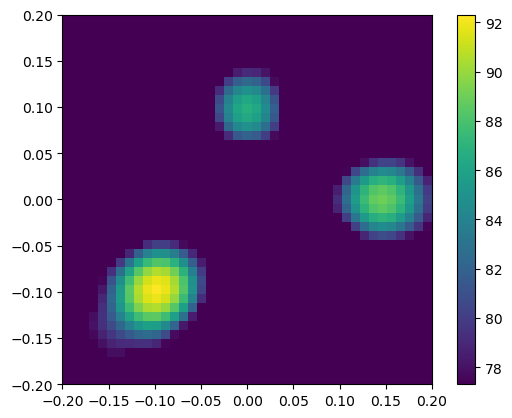

In [2]:
import matplotlib.pyplot as plt
Lm = acoular.L_p( bb.synthetic(8000,3) )
plt.figure()
plt.imshow( Lm.T, origin="lower", vmin=Lm.max()-15, extent=rg.extend() )
plt.colorbar();

The result is obviously the same as before.

It was computed using a variant of the beamformer that applies the _diagonal removal technique_. This setting is the default and it means that we ignore the information in the main diagonal of the CSM, where the auto spectra (self-cross spectra) are stored. This is not too harmful in most cases and has the advantage that the map contains less artifacts. After this explanation, we of course now want to see the result with the full CSM including the diagonal (and hopefully with those artifacts). 

We achieve this by setting the corresponding flag of the `bb` object. Have a look at the documentation on [`BeamformerBase`](http://acoular.org/api_ref/generated/generated/acoular.fbeamform.BeamformerBase.html) to understand the `r_diag` flag.

In [3]:
bb.r_diag = False

Obviously nothing happens (right away). This is due to the lazy evaluation again. To get the result we again have to explicitly ask for it and then we can again plot it. 

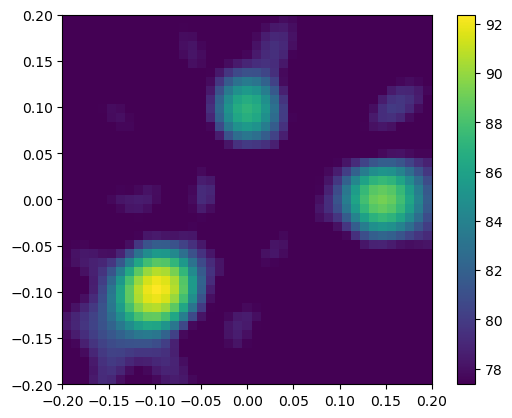

In [4]:
Lm = acoular.L_p( bb.synthetic(8000,3) )
plt.figure()
plt.imshow( Lm.T, origin="lower", vmin=Lm.max()-15, extent=rg.extend() )
plt.colorbar();

Nice! But indeed there are some artifacts that we may have mistaken for additional weak sound sources if we did not know that there are exactly three sound sources.

Changes in other objects will also affect the beamformer. To try this out, we change the file name in the `ts` object. Now this object gets data from new time histories. The `ps` and `bb` objects "know" about this automatically. No need to inform these other objects about the change. We can immediately ask for the new result and it will be computed.

[('three_sources_cache.h5', 1), ('two_sources_cache.h5', 1)]
[('two_sources_cache.h5', 2)]


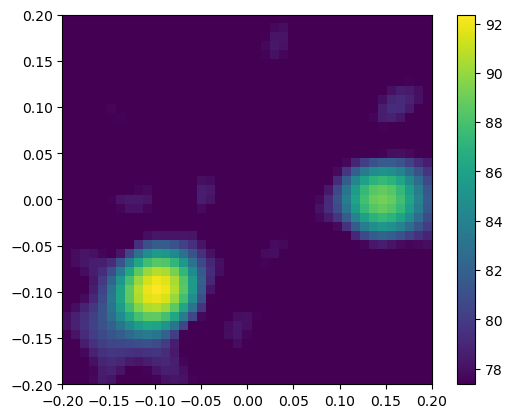

In [5]:
ts.name="two_sources.h5"
Lm = acoular.L_p( bb.synthetic( 8000, 3 ) )
plt.figure()
plt.imshow( Lm.T, origin="lower", vmin=Lm.max()-15, extent=rg.extend() )
plt.colorbar();

There are only two sources. The result is different, obviously!

Now let us try a different type of beamformer. Instead of standard beamforming, we use __functional beamforming__. We set up a new object `bf` and specify the $\gamma$ parameter which is specific to that type of beamformer. We also use the same time histories for the three sources scene as before.

[('two_sources_cache.h5', 2), ('three_sources_cache.h5', 1)]
[('two_sources_cache.h5', 1), ('three_sources_cache.h5', 2)]


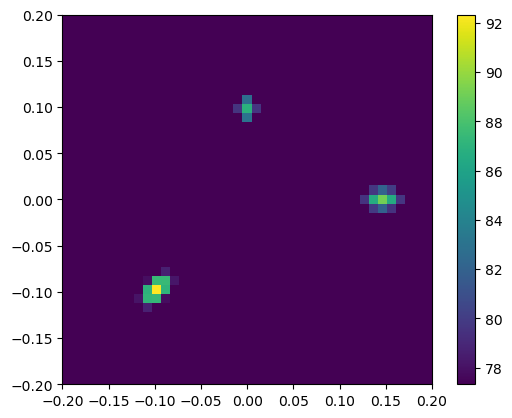

In [6]:
ts.name="three_sources.h5"
bf = acoular.BeamformerFunctional( freq_data=ps, steer=st, gamma=50  )
Lm = acoular.L_p( bf.synthetic(8000,3) )
plt.figure()
plt.imshow( Lm.T, origin="lower", vmin=Lm.max()-15, extent=rg.extend() )
plt.colorbar();

Note the much smaller lobes of this beamformer. In other words, the image is less blurry.

Instead of just beamforming we can apply a __deconvolution__ method. Deconvolution methods aim to remove all blur and artifacts from the result. The original blurry beamforming result can be understood as the _convolution_ of the ideal image with a filter kernel (the point spread function) which is specific to the beamforming algorithm. Deconvolution is any technique that attempts to reverse this convolution.

In Acoular the deconvolution is achieved in a similar way to beamforming. Instead of defining a `BeamformerBase` type of object, we have to use a "beamformer" with deconvolution. In our example we use the CleanSC deconvolution method and `BeamformerCleansc` type of object. Despite the python class name we chose it is not just a beamformer.

[('two_sources_cache.h5', 1), ('three_sources_cache.h5', 3)]
CPU times: user 42.8 s, sys: 51.5 ms, total: 42.9 s
Wall time: 5.67 s


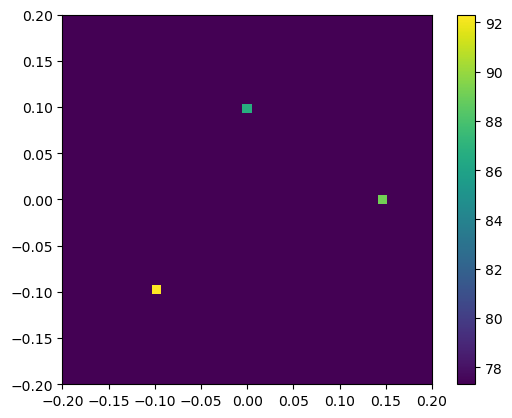

In [7]:
%%time
ts.name="three_sources.h5"
bs = acoular.BeamformerCleansc( freq_data=ps, steer=st )
Lm = acoular.L_p( bs.synthetic( 8000, 3) )
plt.figure()
plt.imshow( Lm.T, origin="lower", vmin=Lm.max()-15, extent=rg.extend() )
plt.colorbar();

Depending on the computer, this computation may take some seconds already. Now there is just one grid "point" per source and the image looks perfect.

You may have noticed that whenever a results is computed, some messages about cache files appear. This happens because all computed results are cached to a file on disk. If one ask for the same result twice, it is still computed only once to save computing time and effort. This even means at the next start of this notebook no recalculation is necessary and all results are immediately available!

We can try out the automatic caching mechanism by setting up another `BeamformerCleansc` object `bs1` with all the same parameters as the `bs` object we did already use. 

In [8]:
bs1 = acoular.BeamformerCleansc( freq_data=ps, steer=st )
print( bs, bs1 )

<acoular.fbeamform.BeamformerCleansc object at 0x7fe88ac444d0> <acoular.fbeamform.BeamformerCleansc object at 0x7fe88ac44b90>


Note that while we have two identical objects, they are not the _same_ object. Thus, the `bs1` does not know about the results while `bs` still does. If we now trigger the computation of the results for `bs1` they are not actually computed, but just read from the cache. No noteable delay will happen when executing the following commands.

[('two_sources_cache.h5', 1), ('three_sources_cache.h5', 4)]
CPU times: user 266 ms, sys: 11 µs, total: 266 ms
Wall time: 264 ms


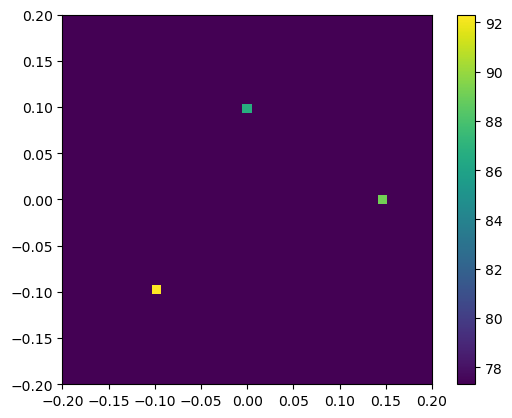

In [9]:
%%time
Lm = acoular.L_p( bs1.synthetic(8000,3) )
plt.figure()
plt.imshow( Lm.T, origin="lower", vmin=Lm.max()-15, extent=rg.extend() )
plt.colorbar();

This is indeed the same result as before.

However, the cache is not used when parameters are changing. This is desirable because the result may also change. We demonstrate this here by changing one parameter of the `bs` object.

In [10]:
print( bs.damp )
bs.damp = 0.99

0.6


With the new value, a new computation is necessary.

CPU times: user 13.3 s, sys: 12.3 ms, total: 13.3 s
Wall time: 1.72 s


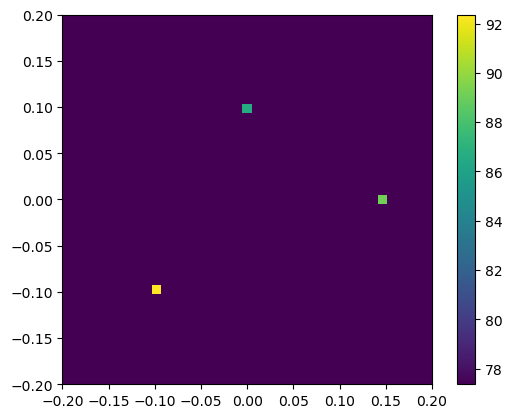

In [11]:
%%time
Lm = acoular.L_p( bs.synthetic( 8000, 3 ) )
plt.figure()
plt.imshow( Lm.T, origin="lower", vmin=Lm.max()-15, extent=rg.extend())
plt.colorbar();

This took again some time. In our simple example the result looks not much different, but there was no way to know this before.

In this blog post, we learned how to use alternative methods like functional beamforming and CleanSC. There are many more such methods implemented in Acoular and now you know how to check them out. The last [part](getstart3) of this blog post series is about time domain beamforming.